In [174]:
# Import libraries and dependencies

import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
import hvplot.pandas
import statsmodels.api as sm
from matplotlib import pyplot as plt

## 1. Reading in the Data

First, we will read in the Ethereum data, using the date as the index. Our data comes from Gemini, a cryptocurrency exchange and trading venue. 

Our dataset contains the following information:
* Date/Time
* Ticker (ETH/USD, in this case)
* Open/High/Low/Close Price, for each hour from 2016-05-09 13:00:00 to 2022-10-13 00:00:00
* Volume traded, denominated in both ETH and USD

In [175]:
# Read in the data 
# The first row in the data gives the soruce, so we need to skip over it
eth = pd.read_csv(Path('../Resources/Gemini_ETHUSD_1h.csv'),
                 skiprows=1,
                  index_col='date',
                  parse_dates=True,
                  infer_datetime_format=True)

# Display data
display(eth.head())
display(eth.tail())

,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2022-10-13 00:00:00,1665619200000,ETH/USD,1294.40,1296.60,1292.46,1295.26,162.209379,210103.320244
2022-10-12 23:00:00,1665615600000,ETH/USD,1294.70,1296.29,1292.87,1294.40,119.920839,155225.534002
2022-10-12 22:00:00,1665612000000,ETH/USD,1299.77,1301.22,1294.44,1294.70,158.825518,205631.398155
2022-10-12 21:00:00,1665608400000,ETH/USD,1298.96,1303.00,1298.77,1299.77,168.917546,219553.958764
2022-10-12 20:00:00,1665604800000,ETH/USD,1297.90,1299.41,1297.01,1298.96,21.727735,28223.458656


,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3127.459991
2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,613.189994
2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,109.625935
2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2357.740748
2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4130.968200


## 2. Data Cleaning

Next, we will complete a number of steps to pre-process the data. This includes:

1. Removing all columns except date/time, closing price, and volume (USD).
2. Calculating hourly returns by calling the 'pct_change()' function
3. Removing hours where no trading occurred (see more details below)

In [176]:
# Remove all data except closing price and volume
eth_prices = eth[['close', 'Volume USD']]

# Reverse the order
eth_prices = eth_prices.sort_index(ascending=True)

display(eth_prices.head())

,close,Volume USD
date,,
2016-05-09 13:00:00,9.55,4130.968200
2016-05-09 14:00:00,10.00,2357.740748
2016-05-09 15:00:00,9.99,109.625935
2016-05-09 16:00:00,9.83,613.189994
2016-05-09 17:00:00,9.49,3127.459991


In [177]:
# Calculate hourly percent change (this will be the response variable) 
eth_prices['hourly_returns'] = eth_prices['close'].pct_change().shift(-1)

display(eth_prices.head())

,close,Volume USD,hourly_returns
date,,,
2016-05-09 13:00:00,9.55,4130.968200,0.047120
2016-05-09 14:00:00,10.00,2357.740748,-0.001000
2016-05-09 15:00:00,9.99,109.625935,-0.016016
2016-05-09 16:00:00,9.83,613.189994,-0.034588
2016-05-09 17:00:00,9.49,3127.459991,-0.013699


In [178]:
# For the regression, we need each row to have the following values (predictors):
# 1. The 20-hour lagged hourly return
# 2. The 24-hour lagged hourly return
# 3. The 28-hour lagged hourly return
# 4. The current month
# 5. The current day
# 6. The current year

# Remove NA rows
eth_prices = eth_prices.dropna()

# Set date/month/year
eth_prices['year'] = eth_prices.index.year
eth_prices['month'] = eth_prices.index.month
eth_prices['day'] = eth_prices.index.day
display(eth_prices.head())

,close,Volume USD,hourly_returns,year,month,day
date,,,,,,
2016-05-09 13:00:00,9.55,4130.968200,0.047120,2016,5,9
2016-05-09 14:00:00,10.00,2357.740748,-0.001000,2016,5,9
2016-05-09 15:00:00,9.99,109.625935,-0.016016,2016,5,9
2016-05-09 16:00:00,9.83,613.189994,-0.034588,2016,5,9
2016-05-09 17:00:00,9.49,3127.459991,-0.013699,2016,5,9


Notice that some of the hours had no trading volume. Looking at how this data varies by year, it becomes clear that almost all of the "zero-volume days" happened before 2018. It seems likely that in the early days of Ethereum, when trading volume was limited, there were more discrepencies in the hourly data. Another explanation is that the Gemini exchange may have halted trading during these periods. In light of this, we will remove these items from the dataset and any rows that reference these rows.

In [179]:
sum(eth_prices['Volume USD'] == 0)
zero_vol = eth_prices[eth_prices['Volume USD'] == 0]

display(zero_vol.groupby('year').count())

,close,Volume USD,hourly_returns,month,day
year,,,,,
2016,1934,1934,1934,1934,1934
2017,389,389,389,389,389
2018,58,58,58,58,58
2019,51,51,51,51,51
2020,33,33,33,33,33
2021,15,15,15,15,15
2022,5,5,5,5,5


In [180]:
# Add NaN values to rows with no volume
eth_prices['hourly_returns'] = np.where(eth_prices['Volume USD'] == 0, np.nan, eth_prices['hourly_returns'])

In [181]:
# Calculate lagged hourly returns
for i in range(1, 60):
    eth_prices[f'lag{i}'] = eth_prices['hourly_returns'].shift(i)


In [182]:
# Remove values that reference hours with zero volume
eth_prices = eth_prices.dropna()

## 3. Modeling

This is where things start to get interesting. Here, we will train a multiple regression model predicting $R_{t, t+1}$, the hourly return from hour $t$ to $t+1$ with each of $\{R_{t-i, t-i+1} | i \in [1, 60]\}$ and an intercept. Then, we will graph the confidence intervals for each of the $R_{t-i, t-i+1}$ to see which lagged hourly returns have the most significant effect on the next hour of returns.

In [189]:
##### Do the model
X = eth_prices.filter(regex='lag')
X = sm.add_constant(X)
Y = eth_prices['hourly_returns']


eth_model = sm.OLS(Y, X).fit()
print(eth_model.summary())

                            OLS Regression Results                            
Dep. Variable:         hourly_returns   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.808
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           3.69e-52
Time:                        12:18:02   Log-Likelihood:             1.2892e+05
No. Observations:               42674   AIC:                        -2.577e+05
Df Residuals:                   42614   BIC:                        -2.572e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   5.75e-05      3.047      0.0

In [188]:
param_err = eth_model.params - eth_model.conf_int()[0]

coef_df = pd.DataFrame({'coef': eth_model.params.values[1:],
                        'err': param_err.values[1:],
                        'varname': param_err.index.values[1:]
                       })

display(coef_df.head())

,coef,err,varname
0,-0.029247,0.009483,lag1
1,-0.033703,0.009504,lag2
2,-0.019834,0.009523,lag3
3,-0.007190,0.009532,lag4
4,-0.008868,0.009535,lag5


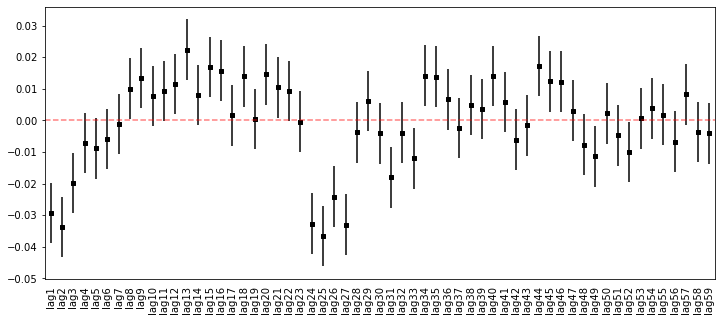

In [185]:
# Create plot figure
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the conf. int
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, 
             yerr='err', legend=False, color='none',
             xlabel='')

# Add the means
ax.scatter(x=np.arange(coef_df.shape[0]),
           marker='s', s=20,
           y=coef_df['coef'], color='black')

# Add zero line
ax.axhline(y=0, color='red', linestyle='--', alpha=.5)
ax.xaxis.set_ticks_position('none')

A few things stand out to us about the above graph and the results of our regression:

* As expected, our results matched the results of the paper we attempted to replicate.
* The effect of the closest lagged returns (hours 1-3) was significant (~2-4 bps). These effects are likely due to features of the market microstructure on Gemini. 
* There are significant positive effects for hours 8, 9, 12, 13, 15, 16, 18, and 21. 
* There are highly significant negative effects for hours 24-27 of about equal size (~2.5-4bps). Interestingly, there is a stark start/end to this trend after hour 23/before hour 28. 
* The same pattern appears to hold, but to a lesser extent, for the next 24 hours of lagged returns.